In [1]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# <img width=50px  src = 'https://apps.fs.usda.gov/lcms-viewer/images/lcms-icon.png'> Lab 6: LCMS Map Assemblage

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/redcastle-resources/lcms-training/blob/main/6-Map_Assemblage.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/redcastle-resources/lcms-training/blob/main/6-Map_Assemblage.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://github.com/redcastle-resources/lcms-training/blob/main/6-Map_Assemblage.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
</table>
<br/><br/><br/>



## 6.0: Overview and Introduction


This notebook teaches how to take raw model outputs and assemble final map classes


### 6.0.1: Objective

In this tutorial, you learn how to manipulate raw model output GEE image arrays to create map outputs of a single class.

This tutorial uses the following Google Cloud services:

- `Google Earth Engine`

The steps performed include:

- Looking at raw GEE image array model output assets
- Manipulating the image arrays for a basic map assemblage
- Performing a more complicated map assemblage that balances omission and commission for Change

### 6.0.2: Before you begin

#### If you are working in Workbench: Set your current URL under `workbench_url`
This gives the Map Viewer a url in which to host the viewer we will be generating. 
* This will be in your URL/search bar at the top of the browser window you are currently in
* It will look something like `https://1234567890122-dot-us-west3.notebooks.googleusercontent.com/` (See the image below)

![workspace url](img/workspace-url.png)

#### Set a folder to use for all exports under `export_path_root` 
* This folder should be an assets folder in an existing GEE project.
* By default, this folder is the same as the pre-baked folder (where outputs have already been created). 
* If you would like to create your own outputs, specify a different path for `export_path_root`, but leave the `pre_baked_path_root` as it was. This way, the pre-baked outputs can be shown at the end, instead of waiting for all exports to finish.
* It will be something like `projects/projectID/assets/newFolder`
* This folder does not have to already exist. If it does not exist, it will be created

**If you are working in Qwiklabs and wish to export:** Copy the project ID from the 'Start Lab' screen into the `projectID` field in `export_path_root`.

In [50]:
workbench_url = 'https://1307eb830a12e633-dot-us-central1.notebooks.googleusercontent.com/'
pre_baked_path_root  = 'projects/rcr-gee/assets/lcms-training'
export_path_root = pre_baked_path_root

print('Done')

Done


#### Installation
First, install necessary Python packages. Uncomment the first line to upgrade geeViz if necessary.

Note that for this module, we're also importing many data science packages such as pandas. 

In [51]:
#Module imports
#!python -m pip install geeViz --upgrade
try:
    import geeViz.getImagesLib as getImagesLib
except:
    !python -m pip install geeViz
    import geeViz.getImagesLib as getImagesLib

import geeViz.changeDetectionLib as changeDetectionLib
import geeViz.assetManagerLib as aml
import geeViz.taskManagerLib as tml
import geeViz.gee2Pandas as g2p
import inspect,operator
import numpy as np
import pandas as pd
import os,json

try:
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import GroupShuffleSplit
    from sklearn.ensemble import RandomForestClassifier
    from sklearn import metrics 
except:
    !pip install -U scikit-learn
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import GroupShuffleSplit
    from sklearn.ensemble import RandomForestClassifier
    from sklearn import metrics 

try:
    import matplotlib.pyplot as plt
except:
    !pip install matplotlib
    import matplotlib.pyplot as plt
    

    
#from IPython.display import IFrame,display, HTML

ee = getImagesLib.ee
Map = getImagesLib.Map

# Can set the port used for viewing map outputs
Map.port = 1235
print('Done')


Done


#### Set up your work environment

Create a folder in your export path where you will export the composites. In addition, create a blank image collection where your composites will live.

Currently, when running within Colab or Workbench, geeView uses a different project to authenticate through, so you may need to make your asset public to view from within Colab.

In [52]:
# Bring in all folders/collections that are needed
# These must already exist as they are created in previous notebooks
export_rawLCMSOutputs_collection = f'{export_path_root}/lcms-training_module-5_rawLCMSOutputs'
export_assembledLCMSOutputs_collection = f'{export_path_root}/lcms-training_module-6_assembledLCMSOutputs'
export_timeSync_folder = f'{export_path_root}/lcms-training_module-4_timeSync'

aml.create_asset(export_assembledLCMSOutputs_collection, asset_type = ee.data.ASSET_TYPE_IMAGE_COLL)

# This is the pre-made TimeSync data
# Creating this dataset is not covered in this set of notebooks
timeSync_featureCollection = 'projects/rcr-gee/assets/training-materials/18_PRVI_AllPlots_TimeSync_Annualized_Table_secLC_wStrata'

# Currently geeView within Colab uses a different project to authenticate through, so you may need to make your asset public to view from within Colab
aml.updateACL(export_assembledLCMSOutputs_collection,writers = [],all_users_can_read = True,readers = [])

# Set folder for local model data
local_model_data_folder = '/tmp/lcms-training/local_modeling'
model_options_csv_filename = './tables/LCMS_model_options_table.csv'
local_training_csv = os.path.join(local_model_data_folder,'timeSync_training_table.csv')



print('Done')

Found the following sub directories:  ['lcms-training', 'lcms-training_module-6_assembledLCMSOutputs']
Will attempt to create them if they do not exist
Asset projects/rcr-gee/assets/lcms-training already exists
Asset projects/rcr-gee/assets/lcms-training/lcms-training_module-6_assembledLCMSOutputs already exists
Updating permissions for:  projects/rcr-gee/assets/lcms-training/lcms-training_module-6_assembledLCMSOutputs
Done


In [58]:
# set up map
Map.clearMap()

# reset port if necessary
Map.port = 1234
Map.proxy_url = workbench_url

print('Done')

Done


## 6.1: Bring in Raw LCMS Outputs and visualize
* You'll see that the raw LCMS outputs are all probabilities


In [54]:
Map.clearMap()
# Bring in raw LCMS model outputs
raw_lcms = ee.ImageCollection(export_rawLCMSOutputs_collection)

In [55]:
Map.clearMap()
# Bring in raw LCMS model outputs
raw_lcms = ee.ImageCollection(export_rawLCMSOutputs_collection)

# Bring in existing LCMS data for the class names, numbers, and colors
lcms_viz_dict = ee.ImageCollection("USFS/GTAC/LCMS/v2022-8").filter('study_area=="PRUSVI"').first().toDictionary().getInfo()
# print(lcms_viz_dict)
    
# Get some info
products = raw_lcms.aggregate_histogram('product').keys().getInfo()


# Specify missing classes in PRUSVI
# Talls Shrubs (2 and 6)  and snow/ice (13) are not present and need filled back in
# Change and Land_Use have all values
missing_names = {'Change':[],
                  'Land_Cover':['Tall Shrubs & Trees Mix (SEAK Only)',
                                'Tall Shrubs (SEAK Only)',
                                'Snow or Ice'],
                  'Land_Use':[]
                 }
def arrayToImage(img,bandNames):
    return img.arrayProject([0])\
            .arrayFlatten([bandNames])\
            .copyProperties(img,['system:time_start'])

# var c = ee.ImageCollection('projects/rcr-gee/assets/lcms-training/lcms-training_module-5_rawLCMSOutputs')
        # .filter(ee.Filter.eq('product','Land_Cover'))

# Function to add in a fill value in a 1-d image array of a given index and value
def fillArray(img,index,fillValue=0):
    imgLeft = img.arraySlice(0,0,index)
    imgRight = img.arraySlice(0,index,None)
    imgLeft = imgLeft.arrayCat(ee.Image(fillValue).toArray(),0)
    out = imgLeft.arrayCat(imgRight,0)
    return ee.Image(out.copyProperties(img).copyProperties(img,['system:time_start']))

# Function to handle filling multiple values
def fillArrayMulti(img,indices,fillValue):
    for index in indices:
        img = fillArray(img,index,fillValue)
    return img

print("Done")

Done


## 6.2: Highest probability assemblage
* Get the class code of the class with the highest probability - the most confident class
* This is the most basic assemblage method and most commonly used
* We will start with this approach and then illustrate when this simple approach may not create the best map in some instances

In [60]:
Map.clearMap()

max_prob_lcms_classes = {}
# Get the class code of the most confident class
# This is the most basic assemblage method and most commonly used
# We will start with this approach and then illustrate when this simple approach may not 
# create the best map in some instances
def getMostProbableClass(raw_lcms_product_yr,product):
    # Pull the index of the most probable value
    # Since 0 is not used for LCMS outputs, add 1
    max_prob_class = raw_lcms_product_yr.arrayArgmax().arrayGet(0).add(1).byte().rename([product])
    max_prob_class = ee.Image(max_prob_class)

    null_code = lcms_viz_dict[f'{product}_class_values'][-1]
    max_prob_class = max_prob_class.unmask(null_code)
    return max_prob_class.copyProperties(raw_lcms_product_yr,['system:time_start'])

# Iterate across each product and assemble the most probable class collection from the raw
for product in products:
    # Pull the class names
    class_names = lcms_viz_dict[f'{product}_class_names'][:-1]
   
    product_title = product.replace('_',' ')
    
    # Filter to only include the product of interest
    raw_lcms_product = raw_lcms.filter(ee.Filter.eq('product',product))
    
    # Fill in any missing values
    missing_names_product = missing_names[product]
    missing_indices_product = [lcms_viz_dict[f'{product}_class_names'].index(missing_name_product) for missing_name_product in missing_names_product]
    
    if len(missing_names_product) > 0:
        raw_lcms_product = raw_lcms_product.map(lambda img: fillArrayMulti(img,missing_indices_product,0))
    
    # Find the max probability class
    maxProb_lcms_product = raw_lcms_product.map(lambda raw_lcms_product_yr:getMostProbableClass(raw_lcms_product_yr,product).set(lcms_viz_dict))
    max_prob_lcms_classes[product] = maxProb_lcms_product
    
    # Convert raw model probabilities to bands for exploration
    raw_lcms_product = raw_lcms_product.map(lambda img:arrayToImage(img,class_names))
    
    # Add the assembed final class maps
    Map.addTimeLapse(maxProb_lcms_product,{'autoViz':True},f'Most Probable LCMS {product_title}')
    
     # Add the raw model probabilities to query
    Map.addTimeLapse(raw_lcms_product,{'addToLegend':False},f'Raw LCMS {product_title}')
Map.turnOnInspector()
Map.view()

print('Done')

Adding layer: Most Probable LCMS Change
Adding layer: Raw LCMS Change
Adding layer: Most Probable LCMS Land Cover
Adding layer: Raw LCMS Land Cover
Adding layer: Most Probable LCMS Land Use
Adding layer: Raw LCMS Land Use
Starting webmap
Using default refresh token for geeView: C:\Users\ianho/.config/earthengine/credentials
Local web server at: http://localhost:1234/geeView/ already serving.
cwd c:\RCR\quickLabsTrainingMaterials\lcms-training


Done


#### Inspect
* Click on the radio buttons next to the layers to turn them on
*
* Turn on "Raw LCMS Land Cover" 

* While the highest probability assemblage method works well, you can introduce various rules to tailor the final map product to different audiences
* In the case of LCMS, there is a focus on forest applications
* We know that our models are generally not very confident about classifying change largely due to the limited number of training samples that experience change
* We also know our land use classes are not mutually exclusive (e.g. non-forest wetlands can potentially occur in any land use)
* Therefore we have a lot of confusion in our land use outputs


* Inspect time series of change probability

* Take note that the Stable is the most probable type of change
* We will need a different assemblage method for change

## 6.3 Compute thresholds for change classes and assemble

* Change is generally a rare class
* As we noted earlier, uur training data have far more stable plots than change plots
* As a result, most of the time, our models are not very confident of change
* We do not use the class the model was most confident of for change classification
* Instead, we take any of the 3 change classes that are above a threshold that balances omission and commission error and then take the most confident classs (should more than one be above their respective thresholds)
* The next blocks compute the thresholds that balance omission and commission
* We do this as a part of our model fitting and model assemblage

### 6.3.1: Set up Random Forest Model for thresholding

#### Load training data
* we have to repeat some steps from the last module, module 5
* to load in and prepare the training data again 

In [14]:
##### This is all from module 5
# Necessary in order to download data for local use

# Bring in raw TS data
timeSyncData = ee.FeatureCollection(timeSync_featureCollection)
timeSync_fields = timeSyncData.first().toDictionary().keys().getInfo()

# Now lets bring in all training data and prep it for modeling
assets = ee.data.listAssets({'parent': export_timeSync_folder})['assets']

# You may need to change the permissions for viewing model outputs in geeViz
# Uncomment this if needed
#for asset in assets:aml.updateACL(asset['name'],writers = [],all_users_can_read = True,readers = [])

# Read in each year of extracted TimeSync data
training_data = ee.FeatureCollection([ee.FeatureCollection(asset['name']) for asset in assets]).flatten()

# Bring in existing LCMS data for the class names, numbers, and colors
lcms_viz_dict = ee.ImageCollection("USFS/GTAC/LCMS/v2022-8").filter('study_area=="PRUSVI"').first().toDictionary().getInfo()
                              
# Get the field names for prediction
# Find any field that was not in the original TimeSync data and assume that is a predictor variable
all_fields = training_data.first().toDictionary().keys().getInfo()
predictor_field_names = [field for field in all_fields if field not in timeSync_fields]

# Take out the date predictor
predictor_field_names = [nm for nm in predictor_field_names if nm != 'year']

# Filter out any non null values (any training plot with missing predictor data will cause the model to fail entirely)
training_data = training_data.filter(ee.Filter.notNull(predictor_field_names))
print('Filtered number of training samples:',training_data.size().getInfo())
print('Done')

Filtered number of training samples: 19778
Done


In [15]:
# Now, we'll crosswalk the training fields to numeric codes
# The TimeSync fields are a string by default
# They must be a number for modeling
# Set up lookup dictionaries to convert the names to numeric codes
land_cover_name_code_dict = ee.Dictionary({'TREES':1,
                             'TSHRUBS-TRE':2,
                             'SHRUBS-TRE':3,
                             'GRASS-TREE':4,
                             'BARREN-TRE':5,
                             'TSHRUBS':6,
                             'SHRUBS':7,
                             'GRASS-SHRU':8,
                             'BARREN-SHR':9,
                             'GRASS':10,
                             'BARREN-GRA':11,
                             'BARREN-IMP':12,
                             'SNOW-ICE':13,
                             'WATER':14
                            })
land_use_name_code_dict = ee.Dictionary({'Agriculture':1,
                           'Developed':2,
                           'Forest':3,
                           'Non-forest Wetland':4,
                           'Other':5,
                           'Rangeland':6
                          })

change_code_dict = ee.Dictionary({'Debris': 3, 
                                  'Fire': 3, 
                                  'Growth/Recovery': 4, 
                                  'Harvest': 3, 'Hydrology': 3, 
                                  'Mechanical': 3, 
                                  'Other': 3, 
                                  'Spectral Decline': 2, 
                                  'Stable': 1, 
                                  'Structural Decline': 2, 
                                  'Wind/Ice': 3})

reference_field_dict = {'Land_Cover':{'field':'DOM_SEC_LC','name_code_dict':land_cover_name_code_dict},
                        'Land_Use':{'field':'DOM_LU','name_code_dict':land_use_name_code_dict},
                        'Change':{'field':'CP','name_code_dict':change_code_dict,
                                  'fields':['Slow Loss', 'Fast Loss', 'Gain']}
                       }


# Make a function that will get the code for a given name and set it
# We could also use the remap function to accomplish this
def set_class_code(plot,product):
    name_fieldName = reference_field_dict[product]['field']
    code_fieldName = ee.String(name_fieldName).cat('_Code')
    name = ee.String(plot.get(name_fieldName))
    code = reference_field_dict[product]['name_code_dict'].get(name)
    plot = plot.set(code_fieldName,code)
    return plot

# set_class_code(training_data.first(),'Land_Cover')
for product in list(reference_field_dict.keys()):
    print('Crosswalking:',product)
    training_data = training_data.map(lambda f:set_class_code(f,product))

print('Done')

Crosswalking: Land_Cover
Crosswalking: Land_Use
Crosswalking: Change
Done


In [16]:
# Now will download the training table to a local location
local_model_data_folder = '/tmp/lcms-training/local_modeling'
local_training_csv = os.path.join(local_model_data_folder,'timeSync_training_table.csv')

if not os.path.exists(local_model_data_folder):os.makedirs(local_model_data_folder)

# Download the training data from a featureCollection to a local CSV
# This function will automatically break the featureCollection into 5000 feature featureCollections
# if it is larger than the 5000 feature limit set by GEE
#g2p.featureCollection_to_csv(training_data,local_training_csv,overwrite = False) # overwrite = false as default
g2p.featureCollection_to_csv(training_data,local_training_csv,overwrite = False) # overwrite = false as default

# Once the table is store locally, read it in
training_df = pd.read_csv(local_training_csv)

training_df.describe()

print(list(filter(lambda c : c.find("CP")>-1 , training_df.columns)))

/tmp/lcms-training/local_modeling\timeSync_training_table.csv  already exists
['CP', 'CP_Code', 'CP_NOTES']


#### Set up RF model parameters

In [17]:
# Specify how many trees to include in the RF model
nTrees=150

# Select which product (we only use this method for Change)
product_name = 'Change'

# load model options df
model_options_df = pd.read_csv(model_options_csv_filename)

# First set up a the predictor and reference field names
model_options_df = model_options_df[model_options_df['Model Name'] == 'Non-correlated Predictors Top 30']

# parse variable names
predictor_variable_names = model_options_df[model_options_df['Product Name'] == product_name]['Var Imp'].values[0]
predictor_variable_names = predictor_variable_names[1:-1]
predictor_variable_names=predictor_variable_names.replace("'","").split(', ')


# get code field names
code_field_name = reference_field_dict[product_name]['field']+'_Code'
print(code_field_name)

#print(predictor_variable_names)
print(training_df[["CP_Code"]].columns)
#print(type(predictor_variable_names))


# # parse code field names
# code_field_name = code_field_name[1:-1]
# code_field_name = code_field_name.replace("'","").split(', ')

# print(type(code_field_name))
# print(code_field_name)


# # Split the training data as we did in module 5 into dependent (y) and independent (X) variables
X = training_df[predictor_variable_names]
y = training_df[code_field_name]
groups = training_df['PLOTID']

seed = 999

# Split them into a test and train set for further model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Ensure all plots are grouped into either test or split so temporally auto-correlated 
# plots do not get into the training set and inflate accuracy
gss = GroupShuffleSplit(n_splits=1, train_size=0.8)
for i, (train_index, test_index) in enumerate(gss.split(X, y, groups)):
    train_index = train_index
    test_index = test_index

X_train, X_test, y_train, y_test = X.iloc[train_index],X.iloc[test_index],y.iloc[train_index],y.iloc[test_index]

print("Done")

CP_Code
Index(['CP_Code'], dtype='object')
Done


### 6.3.2 Run RF model

* This will take some time to run

In [18]:
# Set up a random forest model
print('Fitting models for thresholding')
rf_all = RandomForestClassifier(n_estimators = nTrees, random_state=seed,oob_score=True,)
rf_holdout = RandomForestClassifier(n_estimators = nTrees, random_state=seed,oob_score=True,)

# Fit using all training as well as the holdout
rf_all = rf_all.fit(X,y)
rf_holdout = rf_holdout.fit(X_train,y_train)

# Apply the model and get the proportion of votes for each class
rf_all_probs = rf_all.predict_proba(X)
rf_holdout_probs = rf_holdout.predict_proba(X_test)

print('Done')

Fitting models for thresholding
Done


### 6.3.3: Compute proportion of votes that balance omission and comission
* Next we'll compute the proportion of votes that balances omission and commission


* Since a pixel may have probabilities above the threshold of more than one class, we choose the class with the model confidence that is the highest probability that is also above its respective threshold. 
* e.g. if the fast loss probability is 0.5 and the slow loss probability is 0.35, the pixel will be assigned fast loss
* We will not include stable since stable will be any pixel that is not already assigned to one of the 3 change classes

Stable 1


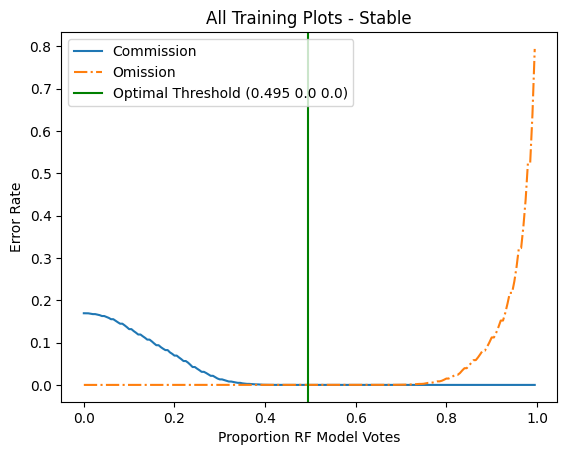

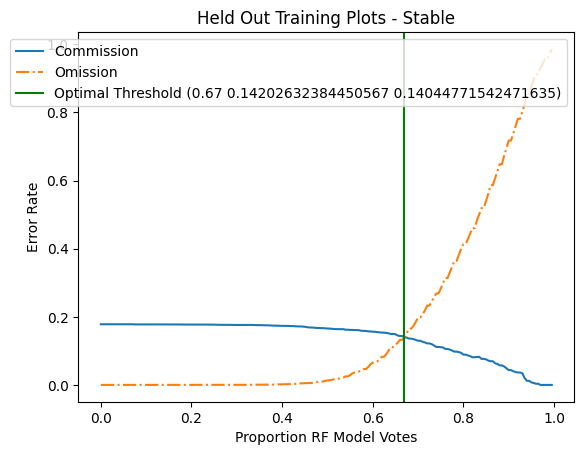

Slow Loss 2


C:\Users\ianho\AppData\Local\Temp\ipykernel_23484\967971049.py:23: RuntimeWarning: invalid value encountered in long_scalars
  commission.append(sum(fp)/sum(pred_positive))


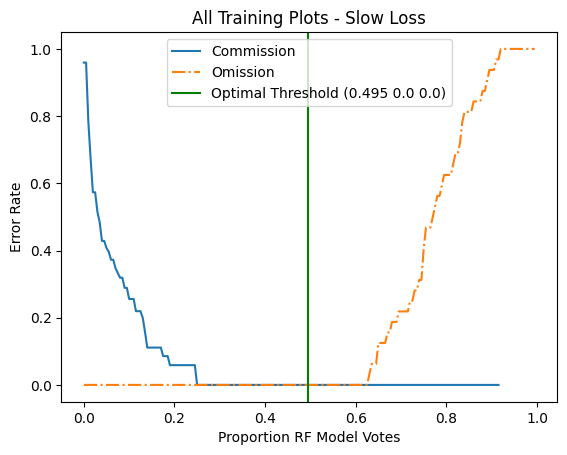

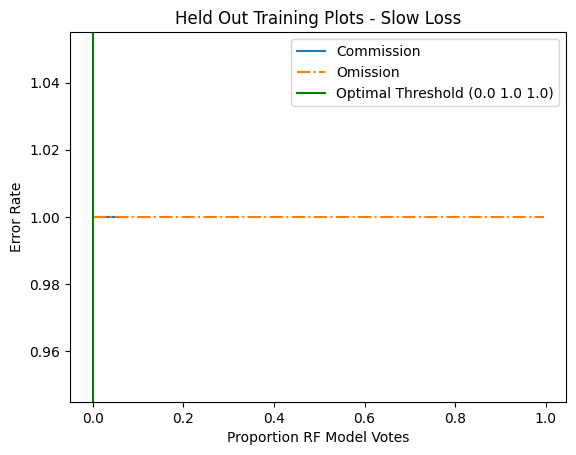

Fast Loss 3


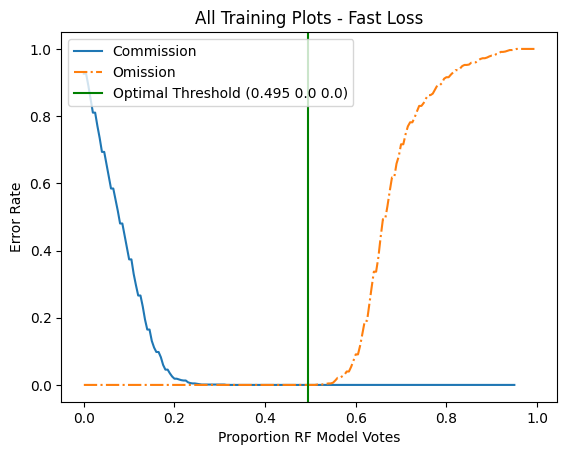

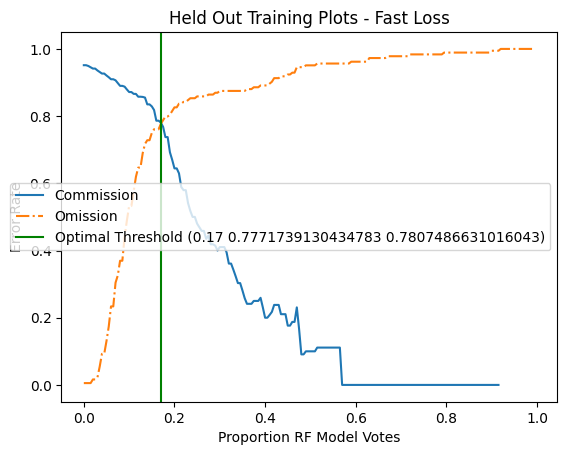

Gain 4


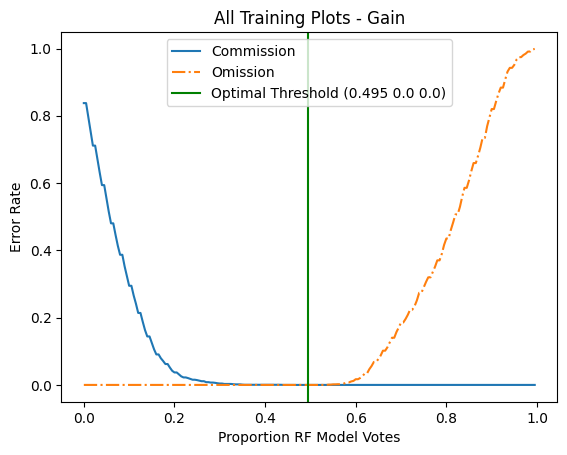

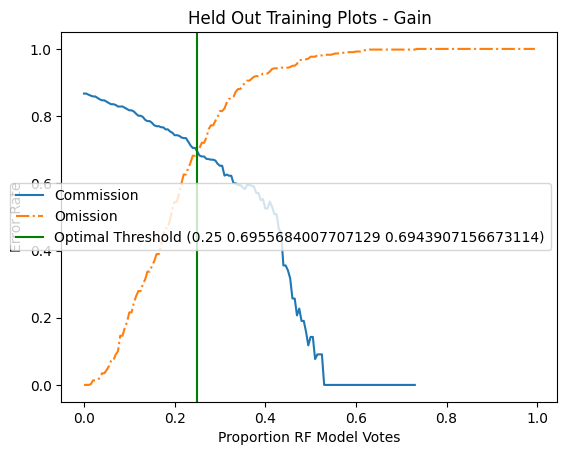

{'Stable': 0.67, 'Slow Loss': 0.0, 'Fast Loss': 0.17, 'Gain': 0.25}
Done


In [19]:
# Next we'll compute the proportion of votes that balances omission and commission

# Specify individual class names and codes for change
change_class_codes = {'Stable':1,'Slow Loss':2,'Fast Loss':3,'Gain':4}

# Make a function that will take a list of binary reference and probablity (0-1 float) 
# predicted values and find the optimal threshold to balance omission and commission
def getBalancedThreshold(y_ref_binary,y_pred_probs,title='Omission-Commission Error',thresholds = list(np.arange(0,1,0.005))):
    
    omission = []
    commission = []
    
    # Iterate across each threshold and compute the omission and commision error rates
    for threshold in thresholds:
        
        y_pred_binary = np.where(y_pred_probs>threshold, 1, 0)
        fp = (y_pred_binary == 1) & (y_ref_binary == 0) 
        pred_positive = y_pred_binary == 1
        ref_positive = y_ref_binary == 1
        ref_negative = y_ref_binary == 0
        fn = (y_pred_binary == 0) & (y_ref_binary == 1) 
        tp = (y_pred_binary == 1) & (y_ref_binary == 1) 
        commission.append(sum(fp)/sum(pred_positive))
        omission.append(sum(fn)/sum(ref_positive))
    
    # Find the threshold that corresponds to the smallest difference between omission and commission
    diff = np.abs(np.array(omission)-np.array(commission))
    diff = np.stack((thresholds,diff,omission,commission),1)
    diff = diff[diff[:, 1].argsort()]
    crossover = diff[0]
    optimal_thresh = crossover[0]
    
    # Plot the curves
    plt.plot(thresholds, commission,label='Commission')
    plt.plot(thresholds,omission, '-.',label='Omission')
    plt.axvline(x = optimal_thresh, color = 'g', label = f'Optimal Threshold ({optimal_thresh} {crossover[2]} {crossover[3]})')
    plt.xlabel("Proportion RF Model Votes")
    plt.ylabel("Error Rate")
    plt.title(title)
    plt.legend()
    plt.show()
    
    return optimal_thresh

# Iterate across each class and find the optimal threshold
out_threshold_dict = {}
for change_class,change_code in list(change_class_codes.items()):
    print(change_class,change_code)
    y_pred_prob_rf_all =rf_all_probs[:,change_code-1]
    y_pred_prob_rf_holdout =rf_holdout_probs[:,change_code-1]
    
    y_ref_binary = np.where(y==change_code, 1, 0)
    y_test_binary = np.where(y_test==change_code,1,0)
    rf_all_thresh = getBalancedThreshold(y_ref_binary,y_pred_prob_rf_all,f'All Training Plots - {change_class}')
    rf_holdout_thresh = getBalancedThreshold(y_test_binary,y_pred_prob_rf_holdout,f'Held Out Training Plots - {change_class}')
    out_threshold_dict[change_class] = rf_holdout_thresh

print(out_threshold_dict)

# Save table for use 
model_change_thresholds_filename = os.path.join(local_model_data_folder,'LCMS_change_thresholds.json')
o = open(model_change_thresholds_filename,'w')
o.write(json.dumps(out_threshold_dict))
o.close()



print('Done')

* Notice if we don't use a holdout, the threshold always hovers near 0.5
    * This is wrong since the model contains the data being used to derive the threshold
* Also notice the slow loss threshold is near zero with an error rate near 1. Recall we have very few slow loss samples. This indicates our models are unlikely to be able to predict slow loss at all.
* Note that both fast loss and gain have thresholds far below 0.5 and error rates around 0.7 or so. This indicates our models are rarely confident of classifying these classes, and the omission and commission error rates are high. 
* Simply put, TimeSync is much more sensitive to detecting change than any model is.

### 6.3.4: Final Change Layer Assemblage

In [73]:
Map.clearMap()

studyArea = ee.FeatureCollection('projects/lcms-292214/assets/R8/PR_USVI/Ancillary/prusvi_boundary')

# Specify which Change classes to include in assemblage
# By default, LCMS only uses Slow Loss, Fast Loss, and Gain and any remaining pixel becomes stable
o = open(model_change_thresholds_filename,'r')
change_thresholds = json.load(o)
o.close()

# Specify which change clases to include
#change_classes = ['Slow Loss','Fast Loss','Gain']
change_classes = ['Fast Loss','Gain']

# Filter to oninclude change classes we want to include 
change_thresholds = {k:v  for k,v in change_thresholds.items() if k in change_classes}

# Specify the Change product
product = 'Change'

# Pull the class names
class_names = lcms_viz_dict[f'{product}_class_names']
class_codes = lcms_viz_dict[f'{product}_class_values']
class_dict = dict(zip(class_names,class_codes))

# Pull the codes in the correct order
class_order_codes = [class_dict[cl] for cl in list(change_thresholds.keys())]

# Filter to only include the product of interest
raw_lcms_product = raw_lcms.filter(ee.Filter.eq('product',product))
    
# Function to assemble change for a given year
# Uses a specified set of bands and thresholds in order to find the highest probability class above its threshold
# It then fills in the stable value as any remaining non null value
# Nulls are then recoded to the non processing code
def assembleChange(img,product):
    # Convert array to multi-band image
    img = ee.Image(arrayToImage(img,lcms_viz_dict[f'{product}_class_names'][:-1]))
    
    # Select only the bands we'd like to assemble
    img = img.select(list(change_thresholds.keys()))
    
    # Find the most confident class
    maxConf = img.reduce(ee.Reducer.max())
    
    # Find pixels that are the most confident and above the threshold
    maxConfMask = img.eq(maxConf).And(img.gte(list(change_thresholds.values()))).selfMask()
    
    # Get class code for any pixel that is above its threshold for the most confident class
    maxClass = ee.Image(class_order_codes).updateMask(maxConfMask).reduce(ee.Reducer.firstNonNull())
    
    # Fill stable back in
    maxClass = maxClass.unmask(1)
    
    # Burn in non processing where the input was null
    maxClass = maxClass.where(img.mask().reduce(ee.Reducer.min()).Not(),class_codes[-1])
    
    return maxClass.rename([product]).copyProperties(img).copyProperties(img,['system:time_start'])

# Iterate across the change probabilities and assemble final change class
assembledChange = raw_lcms_product.map(lambda img:assembleChange(img,product).set(lcms_viz_dict))

# Explore  time lapse on the map
Map.addTimeLapse(assembledChange,{'autoViz':True},'Assembled LCMS Change Time-Lapse')

# Compare the default Change output (max model confidence) and the output that balances
# omission and commission of the change categories
year = 2010
Map.addLayer(max_prob_lcms_classes['Change'].filter(ee.Filter.calendarRange(year,year,'year')),{'autoViz':True},f'LCMS Max Prob Default Change {year}')
Map.addLayer(assembledChange.filter(ee.Filter.calendarRange(year,year,'year')),{'autoViz':True},f'LCMS Balanced Omission/Commission Change {year}')

Map.turnOnInspector()
Map.centerObject(ee.Geometry.Point(-66.095, 18.400), 13)
Map.view()

Adding layer: Assembled LCMS Change Time-Lapse
Adding layer: LCMS Max Prob Default Change 2010
Adding layer: LCMS Balanced Omission/Commission Change 2010
Starting webmap
Using default refresh token for geeView: C:\Users\ianho/.config/earthengine/credentials
Local web server at: http://localhost:1234/geeView/ already serving.
cwd c:\RCR\quickLabsTrainingMaterials\lcms-training


#### Inspect raw probability of change layers

* Compared against assembled change for a single year

In [26]:
#### Inspect raw probability of change layers
Map.clearMap()

# select single year
filterYear = 2017

#print(products)
#print(raw_lcms_product.first().getInfo())
imgs = raw_lcms_product.map(lambda img:arrayToImage(img, lcms_viz_dict['Change_class_names'][:-1]))
imgs = imgs.select(list(['Slow Loss', 'Fast Loss', 'Gain']))
imgs = imgs.filter(ee.Filter.calendarRange(filterYear, filterYear, 'year')).first()

#print(imgs.getInfo())

# Select only the bands we'd like to visualize
raw_slow_loss_prob = imgs.select([0])
raw_fast_loss_prob = imgs.select([1])
raw_gain_prob = imgs.select([2])
    
# Add raw loss probabilities to the map 
Map.addLayer(raw_gain_prob, {'min': 0.1, 'max': 0.4, 'palette': changeDetectionLib.gainMagPalette}, f'Raw Gain Prob {filterYear}') 
Map.addLayer(raw_slow_loss_prob, {'min': 0.1, 'max': 0.3, 'palette': changeDetectionLib.lossMagPalette}, f'Raw Slow Loss Prob {filterYear}')
Map.addLayer(raw_fast_loss_prob, {'min': 0.1, 'max': 0.3, 'palette': changeDetectionLib.lossMagPalette}, f'Raw Fast Loss Prob {filterYear}')


# Add assembled change to map for comparison
Map.addLayer(assembledChange.filter(ee.Filter.calendarRange(filterYear, filterYear, 'year')).first(), {'autoViz': True}, f'Assembled Change {filterYear}')

Map.turnOnInspector()
Map.view()

             

Adding layer: Raw Gain Prob 2017
Adding layer: Raw Slow Loss Prob 2017
Adding layer: Raw Fast Loss Prob 2017
Adding layer: Assembled Change 2017
Starting webmap
Using default refresh token for geeView: C:\Users\ianho/.config/earthengine/credentials
Local web server at: http://localhost:1235/geeView/ already serving.
cwd c:\RCR\quickLabsTrainingMaterials\lcms-training


#### Single Class Year Summaries

* Sometimes instead of looking at individual years, we want to see the most recent year a loss occurred 
* This example will illustratte how to show the most recent year of Fast Loss

In [27]:
Map.clearMap()
# Viewing change outputs can be easier as a composite that shows the most recent year of a single change type
# This example will show the most recent year of fast loss

# First, add a year constant band
assembledChange = assembledChange.map(getImagesLib.addYearBand)

# Then mask where change equals fast loss (3)
fastLoss = assembledChange.map(lambda img: img.updateMask(img.select([0]).eq(3)))

# Find the most recent year
mostRecentFastLoss = fastLoss.max().select(['year'])
Map.addLayer(mostRecentFastLoss,{'min':1985,'max':2022,'palette':changeDetectionLib.lossYearPalette},'Most Recent Year of Fast Loss')

Map.turnOnInspector()
Map.view()
print(assembledChange.first().bandNames().getInfo())

Adding layer: Most Recent Year of Fast Loss
Starting webmap
Using default refresh token for geeView: C:\Users\ianho/.config/earthengine/credentials
Local web server at: http://localhost:1235/geeView/ already serving.
cwd c:\RCR\quickLabsTrainingMaterials\lcms-training


['Change', 'year']


## 6.4: Export Assembled assets

* Now lets export assembled assets

* OPTIONAL!!!!
* Optionally, we can export using the tile grid approach
* For PRUSVI, LCMS does not need to export using this approach, but this is how you would set it up
* First, we'll set up the study area and a tile to export across

In [28]:
Map.clearMap()
# Now lets export assembled assets

# OPTIONAL!!!!
# Optionally, we can export using the tile grid approach
# For PRUSVI, LCMS does not need to export using this approach, but this is how you would set it up

# Specify whether to export across tile grid
# Generally only needed if exports fail due to memory errors
use_tile_grid = False

# First, we'll set up the study area  to export across
studyArea = ee.FeatureCollection('projects/lcms-292214/assets/R8/PR_USVI/Ancillary/prusvi_boundary')

# Set the size (in meters) of the tiles
# We can likely use a large tile for this step
# If exports fail, reducing the tileSize is likely to help
tileSize = 240000


# Set the projection
crs = getImagesLib.common_projections['NLCD_CONUS']['crs']
transform  = getImagesLib.common_projections['NLCD_CONUS']['transform']
scale = None
projection = ee.Projection(crs,transform)


# Get the grid
grid = studyArea.geometry().coveringGrid(projection.atScale(tileSize))
#Map.addLayer(grid,{},'Tile Grid {}m'.format(tileSize))

# Get IDs of tiles
ids = grid.aggregate_histogram('system:index').keys().getInfo()

#Map.centerObject(grid)
#Map.view()
print("Done")

Done


* Iterate across each year and assemble full stack output
* [Example of fully assembed bands](https://developers.google.com/earth-engine/datasets/catalog/USFS_GTAC_LCMS_v2022-8#bands)
* We will not be producing the qa-bits bands

In [47]:
# Iterate across each year, assemble full stack output 
# products = ['Land_Cover','Land_Use']
Map.clearMap()

# Provide a study area name and version
study_area_name = 'PRUSVI'
version = '2022-Training'

# Set up years to apply models across
apply_years = list(range(1985,2022+1))


# This will be populated on the first iteration
pyramidingPolicy = None


for apply_year in apply_years:
    assembled_list = []
    probability_list = []
    for product in products:
        # Pull the class names
        class_names = lcms_viz_dict[f'{product}_class_names'][:-1]
        
        # Filter to only include the product of interest
        raw_lcms_product = raw_lcms.filter(ee.Filter.eq('product',product))
        
        # Get rid of any characters that aren't allowed
        class_names = [nm.replace(' ','-').replace('/','-').replace('&','and').replace('-(SEAK-Only)','') for nm in class_names]
        
        probability_names = [f'{product}_Raw_Probability_{class_name}' for class_name in class_names]
        
        product_title = product.replace('_',' ')

        # Filter to only include the product of interest
        raw_lcms_product_yr = raw_lcms\
                            .filter(ee.Filter.calendarRange(apply_year,apply_year,'year'))\
                            .filter(ee.Filter.eq('product',product)).first()
        
        # Fill in any missing values (Land Cover only for PRUSVI)
        missing_names_product = missing_names[product]
        missing_indices_product = [lcms_viz_dict[f'{product}_class_names'].index(missing_name_product) for missing_name_product in missing_names_product]
        if len(missing_names_product) > 0:
            raw_lcms_product_yr = fillArrayMulti(raw_lcms_product_yr,missing_indices_product,0)

            
        if product in ['Land_Cover','Land_Use']:
            # Find the max probability class
            maxProb_lcms_product_yr = getMostProbableClass(raw_lcms_product_yr,product)
            assembled_list.append(maxProb_lcms_product_yr)
        
        elif product == 'Change':
            change_lcms_product_yr = assembleChange(raw_lcms_product_yr,product)
            assembled_list.append(change_lcms_product_yr)
            
        # Convert raw model probabilities to bands for exploration
        prob_lcms_product_yr = arrayToImage(raw_lcms_product_yr,probability_names)
        probability_list.append(prob_lcms_product_yr)

    # Stack final image with assembed and raw probabilities   
    final_stack = ee.Image(ee.Image.cat([ee.Image.cat(assembled_list),ee.Image.cat(probability_list).multiply(100)]).byte()\
                    .copyProperties(raw_lcms_product_yr,['study_area','year']))
    
    # Set up a pyramiding object for each band
    # Final output bands are thematic and need a mode resampling method
    # Probability bands are continuous, so mean is appropriate
    if pyramidingPolicy == None:
        bns = final_stack.bandNames().getInfo()
        pyramidingPolicy = {}
        for bn in bns:
            if bn.find('_Probability_') == -1:
                pyramidingPolicy[bn] = 'mode'
            else:
                pyramidingPolicy[bn] = 'mean'

    if use_tile_grid:
        for id in ids:
            id_title = id.replace(',','-')

            # Get the tile and buffer it so there are no missing pixels at tile edges
            tile = grid.filter(ee.Filter.eq('system:index',id)).geometry().intersection(studyArea,240,projection).buffer(900)
            final_stack = final_stack.set({'TileSize':tileSize,
                     'TileID':id_title})


            exportName = f'LCMS_{study_area_name}_v{version}_Tile-{tileSize}m_ID{id_title}_{apply_year}'
            exportPath = f'{export_assembledLCMSOutputs_collection}/{exportName}'
            

            getImagesLib.exportToAssetWrapper(final_stack,exportName,exportPath,pyramidingPolicy,tile,scale,crs,transform,overwrite=False)

    else:
        exportName = f'LCMS_{study_area_name}_v{version}_{apply_year}'
        exportPath = f'{export_assembledLCMSOutputs_collection}/{exportName}'

       
        getImagesLib.exportToAssetWrapper(final_stack,exportName,exportPath,pyramidingPolicy,studyArea,scale,crs,transform,overwrite=True)

print('Done')

Exporting: LCMS_PRUSVI_v2022-Training_1985
Exporting: LCMS_PRUSVI_v2022-Training_1986
Exporting: LCMS_PRUSVI_v2022-Training_1987
Exporting: LCMS_PRUSVI_v2022-Training_1988
Exporting: LCMS_PRUSVI_v2022-Training_1989
Exporting: LCMS_PRUSVI_v2022-Training_1990
Exporting: LCMS_PRUSVI_v2022-Training_1991
Exporting: LCMS_PRUSVI_v2022-Training_1992
Exporting: LCMS_PRUSVI_v2022-Training_1993
Exporting: LCMS_PRUSVI_v2022-Training_1994
Exporting: LCMS_PRUSVI_v2022-Training_1995
Exporting: LCMS_PRUSVI_v2022-Training_1996
Exporting: LCMS_PRUSVI_v2022-Training_1997
Exporting: LCMS_PRUSVI_v2022-Training_1998
Exporting: LCMS_PRUSVI_v2022-Training_1999
Exporting: LCMS_PRUSVI_v2022-Training_2000
Exporting: LCMS_PRUSVI_v2022-Training_2001
Exporting: LCMS_PRUSVI_v2022-Training_2002
Exporting: LCMS_PRUSVI_v2022-Training_2003
Exporting: LCMS_PRUSVI_v2022-Training_2004
Exporting: LCMS_PRUSVI_v2022-Training_2005
Exporting: LCMS_PRUSVI_v2022-Training_2006
Exporting: LCMS_PRUSVI_v2022-Training_2007
Exporting: 

In [24]:
# Can track tasks here or at https://code.earthengine.google.com/tasks
# If you'd like to track the tasks, use this:
tml.trackTasks2()

# If you want to cancel all running tasks, you can use this function
# tml.batchCancel()

# If you want to empty the collection of all images
# aml.batchDelete(export_rawLCMSOutputs_collection, type = 'imageCollection')

print('done')

35 tasks ready 2023-09-19 15:04:30
3 tasks running 2023-09-19 15:04:30
Running names:
['LCMS_PRUSVI_v2022-Training_1987', '0:02:03']
['LCMS_PRUSVI_v2022-Training_1986', '0:02:03']
['LCMS_PRUSVI_v2022-Training_1985', '0:02:03']


35 tasks ready 2023-09-19 15:04:36
3 tasks running 2023-09-19 15:04:36
Running names:
['LCMS_PRUSVI_v2022-Training_1987', '0:02:09']
['LCMS_PRUSVI_v2022-Training_1986', '0:02:09']
['LCMS_PRUSVI_v2022-Training_1985', '0:02:09']


35 tasks ready 2023-09-19 15:04:41
3 tasks running 2023-09-19 15:04:41
Running names:
['LCMS_PRUSVI_v2022-Training_1987', '0:02:14']
['LCMS_PRUSVI_v2022-Training_1986', '0:02:14']
['LCMS_PRUSVI_v2022-Training_1985', '0:02:14']


35 tasks ready 2023-09-19 15:04:47
3 tasks running 2023-09-19 15:04:47
Running names:
['LCMS_PRUSVI_v2022-Training_1987', '0:02:20']
['LCMS_PRUSVI_v2022-Training_1986', '0:02:20']
['LCMS_PRUSVI_v2022-Training_1985', '0:02:20']


35 tasks ready 2023-09-19 15:04:53
3 tasks running 2023-09-19 15:04:53
Running names

KeyboardInterrupt: 

### Inspect final outputs

In [49]:
# View final outputs
Map.clearMap()
lcms = ee.ImageCollection(export_assembledLCMSOutputs_collection)

Map.addLayer(lcms,{'opacity':0},'Full Stack Output')
lcms = lcms.map(lambda img:img.set(lcms_viz_dict))
for product in products:Map.addTimeLapse(lcms.select([product]),{'autoViz':True},f'LCMS {product}')

Map.turnOnInspector()
Map.view()

Adding layer: Full Stack Output
Adding layer: LCMS Change
Adding layer: LCMS Land_Cover
Adding layer: LCMS Land_Use
Starting webmap
Using default refresh token for geeView: C:\Users\ianho/.config/earthengine/credentials
Local web server at: http://localhost:1235/geeView/ already serving.
cwd c:\RCR\quickLabsTrainingMaterials\lcms-training


## Lab 6 challenge:

**If you are accessing this lab through Qwiklabs, this challenge will be assessed for completion in Lab 4.**
1. Create a layer that displays the most recent year of gain (class 4)(optionally view it in geeViz)

    * Use the pre-based assembed Change class:

    ```python
          lcms = ee.ImageCollection(export_assembledLCMSOutputs_collection).select(['Change'])

      ```
<br>

2. Extract the year value for the following location. 

* Use a point with these coordinates: `([-66.127, 18.362])`
        
* Use the following function: `g2p.extractPointValuesToDataFrame`
    <br>
    Example:
    ```python
            extracted_values = g2p.extractPointValuesToDataFrame(
            mostRecentGainYear,
            ee.Geometry.Point([-66.127, 18.362]),
            scale=30,
            crs = "EPSG:5070", 
            transform = None,
            reducer = ee.Reducer.first(),
            includeNonSystemProperties = False,
            includeSystemProperties=True
            )
    ```
    <br> 
3. Save extracted values to a csv file.

   * Save csv to this path: `"/tmp/challenge/module_6_challenge_answer.csv"`
     * **Note: The path to the csv must exactly match the path above.** 
    <br>
    
    * Create the `"/tmp/challenge"` folder if it does not already exist.
      
        Example:
    ```python
        out_csv = "/tmp/challenge/module_6_challenge_answer.csv"
        if not os.path.exists(os.path.dirname(out_csv)):os.makedirs(os.path.dirname(out_csv))
    ```
<br>

4.  Check that the output csv exists.
    
    * Example: 
    ```python
        print(os.path.exists(out_csv))
    ```
<br>

In [80]:
# insert challenge code here
Map.clearMap()

# Bring in assembled LCMS
lcms = ee.ImageCollection(export_assembledLCMSOutputs_collection).select(['Change'])

# Add year band
lcms = lcms.map(getImagesLib.addYearBand)

# Mask where change equals gain (4)
gain = lcms.map(lambda img: img.updateMask(img.select([0]).eq(4)))

# Find the most recent year
mostRecentGainYear = gain.max().select(['year'])
Map.addLayer(mostRecentGainYear,{'min':1985,'max':2022,'palette':changeDetectionLib.gainYearPalette},'Most Recent Year of Gain')

Map.turnOnInspector()
Map.view()

extracted_values = g2p.extractPointValuesToDataFrame(
            mostRecentGainYear,
            ee.Geometry.Point([-66.127, 18.362]),
            scale=30,
            crs = "EPSG:5070", 
            transform = None,
            reducer = ee.Reducer.first(),
            includeNonSystemProperties = False,
            includeSystemProperties=True
            )
display(extracted_values)

# Save csv
out_csv = "/tmp/challenge/module_6_challenge_answer.csv"
if not os.path.exists(os.path.dirname(out_csv)):os.makedirs(os.path.dirname(out_csv))
extracted_values.to_csv(out_csv)

# Check to ensure csv exists
print(os.path.exists(out_csv))

Adding layer: Most Recent Year of Gain
Starting webmap
Using default refresh token for geeView: C:\Users\ianho/.config/earthengine/credentials
Local web server at: http://localhost:1234/geeView/ already serving.
cwd c:\RCR\quickLabsTrainingMaterials\lcms-training


,year
0,1988


True


## Done with Module 6